# 🏖️ Proiezioni Pensionistiche Italia

Calcoli pensionistici secondo normativa italiana e pianificazione successione.

**Data creazione**: 18/07/2025

---

In [1]:
# 📁 SETUP E CARICAMENTO DATI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configurazione grafici
plt.style.use('default')
# Configurazione colori matplotlib (equivalente a seaborn viridis)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 10)))
plt.rcParams['figure.figsize'] = (12, 8)

# Carica dati con encoding corretto
try:
    df = pd.read_csv('hr_data_con_turnover.csv', encoding='utf-8')
    print(f"Dataset caricato: {len(df)} dipendenti")
    
    # Converti date
    date_columns = ['DateOfBirth', 'HiringDate', 'TerminationDate']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')
    
    # Calcola età e anzianità
    oggi = pd.Timestamp.now()
    if 'DateOfBirth' in df.columns:
        eta_days = (oggi - df['DateOfBirth']).dt.days
        df['Eta'] = (eta_days / 365.25).round().astype('Int64')
    
    if 'HiringDate' in df.columns:
        servizio_days = (oggi - df['HiringDate']).dt.days
        df['AnniServizio'] = (servizio_days / 365.25).round().astype('Int64')
    
    print("Dati preparati per l'analisi!")
    
except UnicodeDecodeError:
    # Fallback con encoding diverso
    try:
        df = pd.read_csv('hr_data_con_turnover.csv', encoding='latin-1')
        print(f"Dataset caricato con encoding latin-1: {len(df)} dipendenti")
        # Ripeti la preparazione dati
        date_columns = ['DateOfBirth', 'HiringDate', 'TerminationDate']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')
        oggi = pd.Timestamp.now()
        if 'DateOfBirth' in df.columns:
            eta_days = (oggi - df['DateOfBirth']).dt.days
            df['Eta'] = (eta_days / 365.25).round().astype('Int64')
        if 'HiringDate' in df.columns:
            servizio_days = (oggi - df['HiringDate']).dt.days
            df['AnniServizio'] = (servizio_days / 365.25).round().astype('Int64')
        print("Dati preparati per l'analisi!")
    except:
        print("Errore nel caricamento del dataset")
        df = None
except Exception as e:
    print(f"Errore: {e}")
    df = None

Dataset caricato: 250 dipendenti
Dati preparati per l'analisi!


In [2]:

# 📁 Importazione dati dal dashboard principale
# Esegui prima il dashboard principale per caricare i dati

try:
    # Verifica se i dati sono già caricati
    if 'df' in globals():
        print(f"✅ Dati già disponibili: {len(df)} dipendenti")
    else:
        # Carica i dati direttamente
        exec(open('carica_dati_hr.py').read())
        print(f"✅ Dati caricati: {len(df)} dipendenti")
except:
    print("⚠️  Esegui prima il dashboard principale (00_HR_Dashboard_Principale.ipynb)")
    print("   oppure carica manualmente i dati HR")


✅ Dati già disponibili: 250 dipendenti



## 📋 Normativa Pensionistica Italiana 2024

### 🏛️ **Leggi di Riferimento:**

1. **Pensione di Vecchiaia**: 67 anni (Legge Fornero)
2. **Pensione Anticipata**: 
   - Uomini: 42 anni e 10 mesi di contributi
   - Donne: 41 anni e 10 mesi di contributi
3. **Quota 103** (fino al 2024): 62 anni + 41 anni di contributi
4. **Opzione Donna**: Condizioni specifiche per lavoratrici

### ⚖️ **Metodologia di Calcolo:**
- Stima anni contributivi totali basata su età di inizio lavoro
- Identificazione automatica della pensione più vicina
- Proiezioni per dipartimento e impatto economico



## 🧮 Calcoli Proiezioni Pensionistiche

Calcolo automatico secondo la normativa italiana vigente.


In [3]:

# 🧮 CALCOLI PROIEZIONI PENSIONISTICHE ITALIA
if df is not None:
    print("🏖️ PROIEZIONI PENSIONISTICHE - LEGGI ITALIANE 2024")
    print("=" * 60)
    
    # Filtra solo dipendenti attivi per l'analisi pensionistica
    if 'EmploymentStatus' in df.columns:
        df_pensioni = df[df['EmploymentStatus'] == 'Active'].copy()
        print(f"👥 Analisi su {len(df_pensioni)} dipendenti attivi")
    else:
        df_pensioni = df.copy()
        print(f"👥 Analisi su {len(df_pensioni)} dipendenti totali")
    
    # Verifica presenza dati necessari
    if 'Eta' not in df_pensioni.columns or 'AnniServizio' not in df_pensioni.columns:
        print("⚠️  Calcolo età e anzianità...")
        oggi = pd.Timestamp.now()
        if 'DateOfBirth' in df_pensioni.columns:
            eta_days = (oggi - df_pensioni['DateOfBirth']).dt.days
            df_pensioni['Eta'] = (eta_days / 365.25).round(1)
        if 'HiringDate' in df_pensioni.columns:
            servizio_days = (oggi - df_pensioni['HiringDate']).dt.days
            df_pensioni['AnniServizio'] = (servizio_days / 365.25).round(1)
    
    # CALCOLI SECONDO NORMATIVA ITALIANA
    
    # 1. Pensione di vecchiaia: 67 anni
    df_pensioni['AnniAllaPensioneVecchiaia'] = 67 - df_pensioni['Eta']
    
    # 2. Pensione anticipata: stima anni contributivi totali
    # Assumiamo inizio lavoro tra 18-22 anni (media 20)
    df_pensioni['EtaInizioLavoro'] = np.where(
        df_pensioni['Eta'] - df_pensioni['AnniServizio'] < 18, 
        18, 
        np.where(df_pensioni['Eta'] - df_pensioni['AnniServizio'] > 25, 25,
                df_pensioni['Eta'] - df_pensioni['AnniServizio'])
    )
    df_pensioni['AnniContributiviTotali'] = df_pensioni['Eta'] - df_pensioni['EtaInizioLavoro']
    
    # Anni contributivi necessari per pensione anticipata
    df_pensioni['AnniContributiviNecessari'] = np.where(
        df_pensioni['Gender'] == 'M', 
        42.83,  # 42 anni e 10 mesi
        41.83   # 41 anni e 10 mesi
    )
    df_pensioni['AnniAllaPensioneAnticipata'] = (
        df_pensioni['AnniContributiviNecessari'] - df_pensioni['AnniContributiviTotali']
    )
    
    # 3. Quota 103: 62 anni + 41 anni di contributi
    df_pensioni['AnniAllaQuota103_Eta'] = 62 - df_pensioni['Eta']
    df_pensioni['AnniAllaQuota103_Contributi'] = 41 - df_pensioni['AnniContributiviTotali']
    df_pensioni['AnniAllaQuota103'] = np.maximum(
        df_pensioni['AnniAllaQuota103_Eta'], 
        df_pensioni['AnniAllaQuota103_Contributi']
    )
    
    # Determina la pensione più vicina
    pensioni_possibili = df_pensioni[['AnniAllaPensioneVecchiaia', 'AnniAllaPensioneAnticipata', 'AnniAllaQuota103']]
    df_pensioni['AnniAllaPensionePiuVicina'] = pensioni_possibili.min(axis=1)
    df_pensioni['TipoPensionePiuVicina'] = pensioni_possibili.idxmin(axis=1)
    
    # Sostituisci i nomi delle colonne con nomi più leggibili
    tipo_pensione_map = {
        'AnniAllaPensioneVecchiaia': 'Vecchiaia (67 anni)',
        'AnniAllaPensioneAnticipata': 'Anticipata (contributi)',
        'AnniAllaQuota103': 'Quota 103'
    }
    df_pensioni['TipoPensionePiuVicina'] = df_pensioni['TipoPensionePiuVicina'].map(tipo_pensione_map)
    
    # Calcola anno di pensionamento
    df_pensioni['AnnoPensionamento'] = (pd.Timestamp.now().year + df_pensioni['AnniAllaPensionePiuVicina']).round().astype(int)
    
    print("✅ Calcoli pensionistici completati secondo normativa italiana!")


🏖️ PROIEZIONI PENSIONISTICHE - LEGGI ITALIANE 2024
👥 Analisi su 150 dipendenti attivi
✅ Calcoli pensionistici completati secondo normativa italiana!



## 📊 Analisi Impatto Pensionistico

Valutazione dell'impatto delle proiezioni pensionistiche sull'organizzazione.


In [4]:

# 📊 ANALISI IMPATTO PENSIONISTICO
if 'df_pensioni' in locals():
    
    total_employees = len(df_pensioni)
    
    # 1. Distribuzione per fasce temporali
    fasce_pensione = {
        'Già in pensione': len(df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 0]),
        'Entro 1 anno': len(df_pensioni[(df_pensioni['AnniAllaPensionePiuVicina'] > 0) & (df_pensioni['AnniAllaPensionePiuVicina'] <= 1)]),
        'Entro 2-3 anni': len(df_pensioni[(df_pensioni['AnniAllaPensionePiuVicina'] > 1) & (df_pensioni['AnniAllaPensionePiuVicina'] <= 3)]),
        'Entro 4-5 anni': len(df_pensioni[(df_pensioni['AnniAllaPensionePiuVicina'] > 3) & (df_pensioni['AnniAllaPensionePiuVicina'] <= 5)]),
        'Entro 6-10 anni': len(df_pensioni[(df_pensioni['AnniAllaPensionePiuVicina'] > 5) & (df_pensioni['AnniAllaPensionePiuVicina'] <= 10)]),
        'Oltre 10 anni': len(df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] > 10])
    }
    
    print("📊 **DISTRIBUZIONE PENSIONAMENTI PER FASCE TEMPORALI:**")
    for fascia, count in fasce_pensione.items():
        pct = count / total_employees * 100
        status_icon = "🚨" if "1 anno" in fascia else "⚠️" if "2-3 anni" in fascia else "📋" if "4-5 anni" in fascia else "📈"
        print(f"   {status_icon} {fascia}: {count} dipendenti ({pct:.1f}%)")
    
    # 2. Analisi per dipartimento
    if 'Department' in df_pensioni.columns:
        print(f"\n🏢 **PENSIONAMENTI PER DIPARTIMENTO (Prossimi 5 anni):**")
        pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
        
        if len(pensioni_5_anni) > 0:
            dept_pensioni = pensioni_5_anni['Department'].value_counts()
            for dept, count in dept_pensioni.items():
                total_dept = len(df_pensioni[df_pensioni['Department'] == dept])
                pct = count / total_dept * 100
                risk_icon = "🚨" if pct > 30 else "⚠️" if pct > 20 else "📋" if pct > 10 else "✅"
                print(f"   {risk_icon} {dept}: {count}/{total_dept} dipendenti ({pct:.1f}%)")
    
    # 3. Analisi per tipo di pensione
    print(f"\n🎯 **MODALITÀ DI PENSIONAMENTO (Prossimi 10 anni):**")
    pensioni_10_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 10]
    if len(pensioni_10_anni) > 0:
        tipo_pensioni = pensioni_10_anni['TipoPensionePiuVicina'].value_counts()
        for tipo, count in tipo_pensioni.items():
            pct = count / len(pensioni_10_anni) * 100
            print(f"   • {tipo}: {count} dipendenti ({pct:.1f}%)")
    
    # 4. Impatto economico
    if 'Salary' in df_pensioni.columns:
        pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
        if len(pensioni_5_anni) > 0:
            print(f"\n💰 **IMPATTO ECONOMICO PENSIONAMENTI:**")
            stipendio_medio_pensionandi = pensioni_5_anni['Salary'].mean()
            costo_totale_5_anni = pensioni_5_anni['Salary'].sum()
            print(f"   • Stipendio medio pensionandi (5 anni): €{stipendio_medio_pensionandi:,.0f}")
            print(f"   • Costo salariale totale a rischio: €{costo_totale_5_anni:,.0f}/anno")
            print(f"   • Risparmio potenziale: €{costo_totale_5_anni:,.0f}/anno")
            print(f"   • Costo sostituzione stimato: €{costo_totale_5_anni * 0.3:,.0f} (30% del costo)")
    
    # 5. Knowledge at risk
    pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
    if len(pensioni_5_anni) > 0:
        anzianita_media_pensionandi = pensioni_5_anni['AnniServizio'].mean()
        print(f"\n🧠 **KNOWLEDGE AT RISK:**")
        print(f"   • Anzianità media pensionandi: {anzianita_media_pensionandi:.1f} anni")
        print(f"   • Esperienza totale a rischio: {pensioni_5_anni['AnniServizio'].sum():.0f} anni-persona")
        print(f"   • Dipendenti con >20 anni esperienza: {len(pensioni_5_anni[pensioni_5_anni['AnniServizio'] > 20])}")


📊 **DISTRIBUZIONE PENSIONAMENTI PER FASCE TEMPORALI:**
   📈 Già in pensione: 4 dipendenti (2.7%)
   🚨 Entro 1 anno: 7 dipendenti (4.7%)
   ⚠️ Entro 2-3 anni: 12 dipendenti (8.0%)
   📋 Entro 4-5 anni: 12 dipendenti (8.0%)
   📈 Entro 6-10 anni: 23 dipendenti (15.3%)
   📈 Oltre 10 anni: 92 dipendenti (61.3%)

🏢 **PENSIONAMENTI PER DIPARTIMENTO (Prossimi 5 anni):**
   ⚠️ Vendite: 12/43 dipendenti (27.9%)
   ⚠️ Produzione: 11/41 dipendenti (26.8%)
   📋 IT: 8/41 dipendenti (19.5%)
   📋 Amministrazione: 4/25 dipendenti (16.0%)

🎯 **MODALITÀ DI PENSIONAMENTO (Prossimi 10 anni):**
   • Quota 103: 58 dipendenti (100.0%)

💰 **IMPATTO ECONOMICO PENSIONAMENTI:**
   • Stipendio medio pensionandi (5 anni): €41,760
   • Costo salariale totale a rischio: €1,461,607/anno
   • Risparmio potenziale: €1,461,607/anno
   • Costo sostituzione stimato: €438,482 (30% del costo)

🧠 **KNOWLEDGE AT RISK:**
   • Anzianità media pensionandi: 10.6 anni
   • Esperienza totale a rischio: 371 anni-persona
   • Dipendent


## 🎯 Raccomandazioni Strategiche

Piano di azione per gestire l'impatto delle proiezioni pensionistiche.


In [5]:

# 🎯 RACCOMANDAZIONI STRATEGICHE PENSIONISTICHE
if 'df_pensioni' in locals():
    
    print("🎯 RACCOMANDAZIONI STRATEGICHE - PIANIFICAZIONE SUCCESSIONE")
    print("=" * 65)
    
    pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
    pct_pensioni_5_anni = len(pensioni_5_anni) / len(df_pensioni) * 100
    
    print(f"📊 **SITUAZIONE ATTUALE:**")
    print(f"   • Dipendenti in pensione entro 5 anni: {len(pensioni_5_anni)} ({pct_pensioni_5_anni:.1f}%)")
    print(f"   • Dipendenti in pensione entro 10 anni: {len(df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 10])}")
    
    print(f"\n🚨 **PRIORITÀ IMMEDIATE:**")
    
    if pct_pensioni_5_anni > 20:
        print(f"   1. 🆘 **EMERGENZA PENSIONAMENTI**: {pct_pensioni_5_anni:.1f}% va in pensione entro 5 anni!")
        print(f"      → Piano di successione IMMEDIATO per tutti i ruoli critici")
        print(f"      → Task force dedicata al knowledge transfer")
        print(f"      → Accelerazione programmi di formazione interni")
        
    elif pct_pensioni_5_anni > 10:
        print(f"   1. ⚠️  **ALTO RISCHIO**: {pct_pensioni_5_anni:.1f}% va in pensione entro 5 anni")
        print(f"      → Pianificazione sostituzioni per ruoli chiave")
        print(f"      → Programmi di mentoring senior-junior")
        print(f"      → Documentazione processi critici")
        
    elif pct_pensioni_5_anni > 5:
        print(f"   1. 📋 **MONITORAGGIO**: {pct_pensioni_5_anni:.1f}% va in pensione entro 5 anni")
        print(f"      → Pianificazione graduale delle sostituzioni")
        print(f"      → Identificazione talenti interni")
        
    else:
        print(f"   1. ✅ **SITUAZIONE STABILE**: Solo {pct_pensioni_5_anni:.1f}% va in pensione entro 5 anni")
        print(f"      → Mantenimento programmi di sviluppo standard")
    
    # Raccomandazioni specifiche per dipartimenti critici
    if 'Department' in df_pensioni.columns and len(pensioni_5_anni) > 0:
        dept_pensioni = pensioni_5_anni['Department'].value_counts()
        dept_critici = []
        
        for dept, count in dept_pensioni.items():
            total_dept = len(df_pensioni[df_pensioni['Department'] == dept])
            pct_dept = count / total_dept * 100
            if pct_dept > 15:  # Più del 15% del dipartimento
                dept_critici.append((dept, count, total_dept, pct_dept))
        
        if dept_critici:
            print(f"\n🏢 **DIPARTIMENTI CRITICI** (>15% pensionamenti):")
            for dept, count, total, pct in dept_critici:
                print(f"   • **{dept}**: {count}/{total} dipendenti ({pct:.1f}%)")
                print(f"     → Pianificazione urgente sostituzioni")
                print(f"     → Identificazione competenze chiave")
                print(f"     → Programmi di cross-training")
    
    print(f"\n📋 **AZIONI STRATEGICHE A MEDIO TERMINE:**")
    print(f"   • 👥 **Talent Pipeline**: Identificazione e sviluppo successori")
    print(f"   • 📚 **Knowledge Management**: Documentazione expertise critica")
    print(f"   • 🎓 **Programmi di Formazione**: Accelerazione sviluppo competenze")
    print(f"   • 🤝 **Mentoring**: Pairing senior-junior sistematico")
    print(f"   • 💼 **Retention**: Incentivi per posticipare pensionamento (dove possibile)")
    
    print(f"\n📊 **MONITORAGGIO E CONTROLLO:**")
    print(f"   • Dashboard pensionamenti in tempo reale")
    print(f"   • Review trimestrale piani di successione")
    print(f"   • KPI di readiness per sostituzioni")
    print(f"   • Alert automatici per pensionamenti imminenti")
    
    # Calcolo ROI investimenti in successione
    if 'Salary' in df_pensioni.columns and len(pensioni_5_anni) > 0:
        costo_totale_pensionandi = pensioni_5_anni['Salary'].sum()
        costo_sostituzione_stimato = costo_totale_pensionandi * 0.3  # 30% del costo annuale
        
        print(f"\n💰 **ANALISI COSTI-BENEFICI:**")
        print(f"   • Costo sostituzione stimato: €{costo_sostituzione_stimato:,.0f}")
        print(f"   • Investimento in successione raccomandato: €{costo_sostituzione_stimato * 0.2:,.0f} (20%)")
        print(f"   • ROI atteso: Riduzione 50% costi sostituzione e tempi di inserimento")


🎯 RACCOMANDAZIONI STRATEGICHE - PIANIFICAZIONE SUCCESSIONE
📊 **SITUAZIONE ATTUALE:**
   • Dipendenti in pensione entro 5 anni: 35 (23.3%)
   • Dipendenti in pensione entro 10 anni: 58

🚨 **PRIORITÀ IMMEDIATE:**
   1. 🆘 **EMERGENZA PENSIONAMENTI**: 23.3% va in pensione entro 5 anni!
      → Piano di successione IMMEDIATO per tutti i ruoli critici
      → Task force dedicata al knowledge transfer
      → Accelerazione programmi di formazione interni

🏢 **DIPARTIMENTI CRITICI** (>15% pensionamenti):
   • **Vendite**: 12/43 dipendenti (27.9%)
     → Pianificazione urgente sostituzioni
     → Identificazione competenze chiave
     → Programmi di cross-training
   • **Produzione**: 11/41 dipendenti (26.8%)
     → Pianificazione urgente sostituzioni
     → Identificazione competenze chiave
     → Programmi di cross-training
   • **IT**: 8/41 dipendenti (19.5%)
     → Pianificazione urgente sostituzioni
     → Identificazione competenze chiave
     → Programmi di cross-training
   • **Amminist


## 📊 Visualizzazioni Proiezioni Pensionistiche

Grafici per comprendere l'impatto temporale delle pensioni.


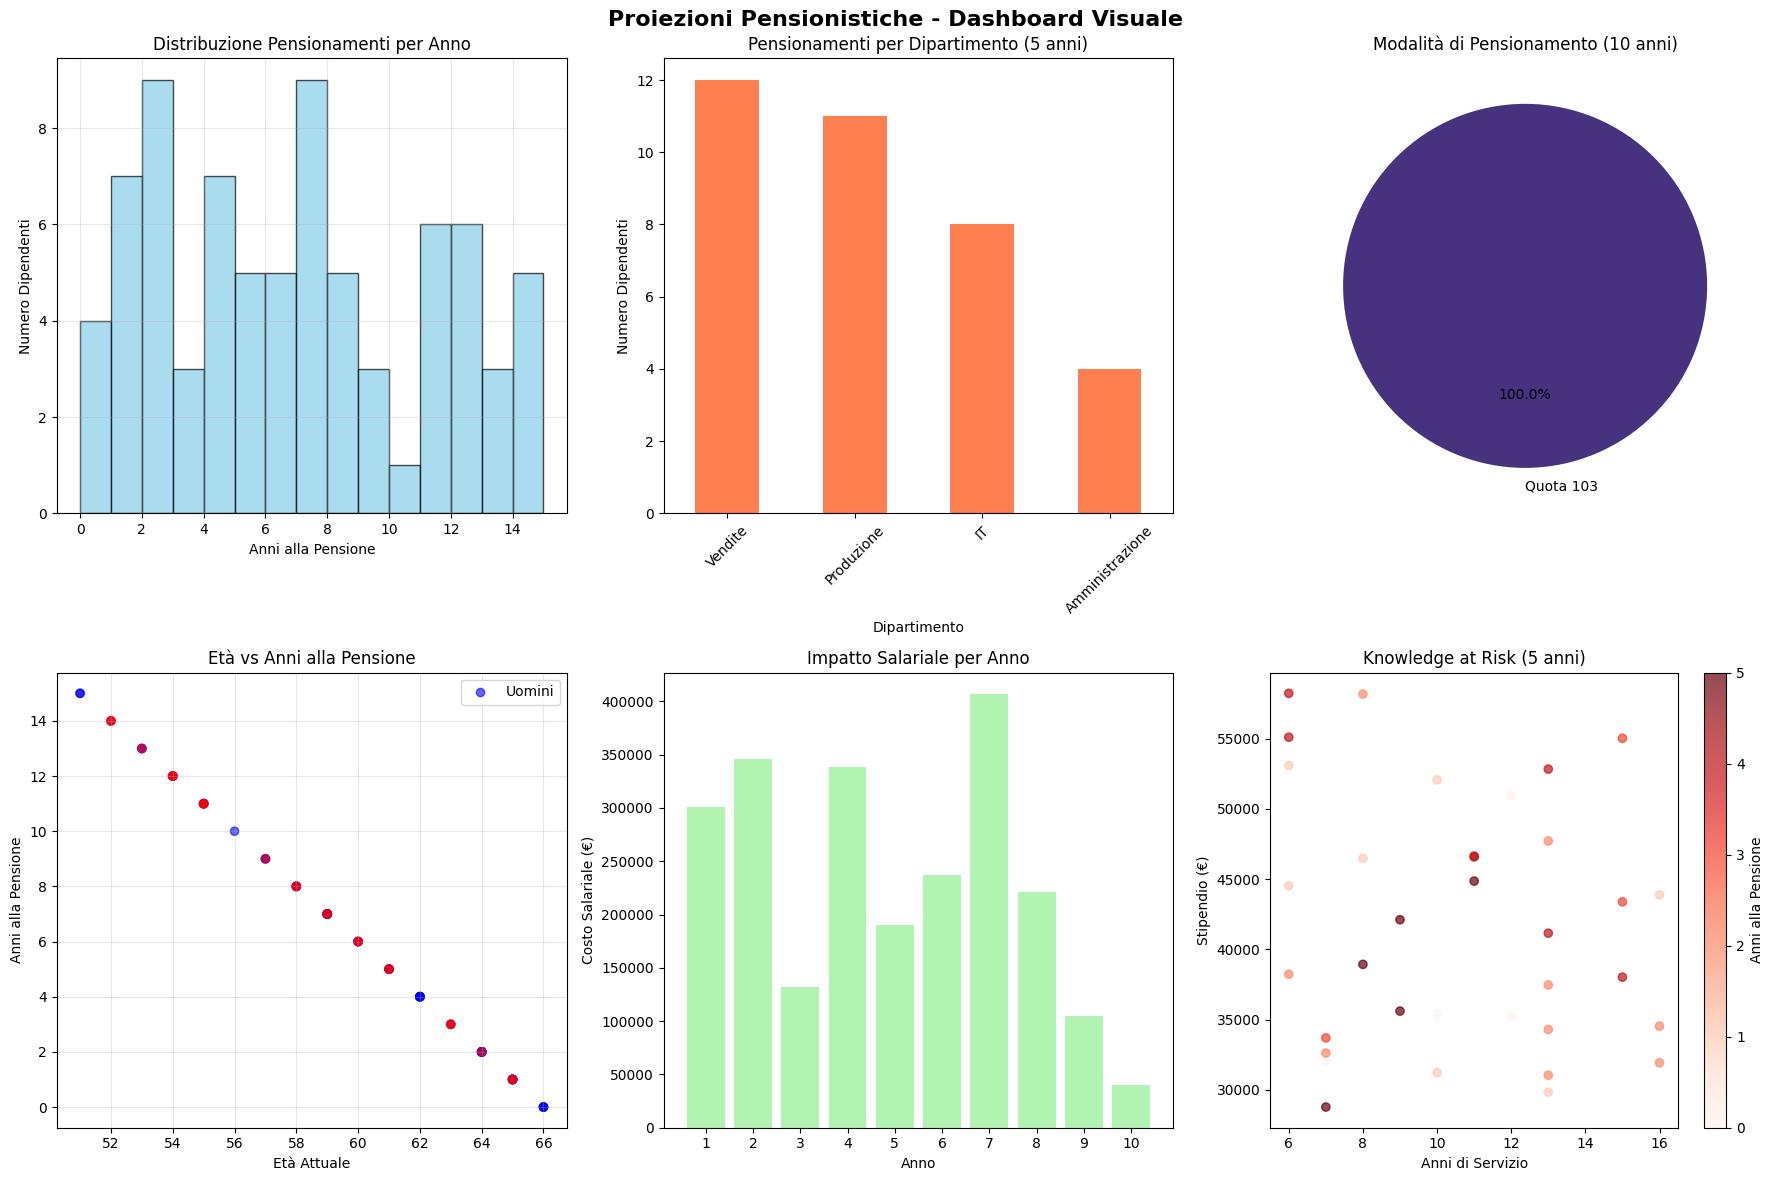


🎯 Utilizzare questi grafici per presentazioni alla leadership!
📊 Dashboard aggiornato automaticamente con i dati più recenti


In [6]:

# 📊 VISUALIZZAZIONI PROIEZIONI PENSIONISTICHE
if 'df_pensioni' in locals():
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Proiezioni Pensionistiche - Dashboard Visuale', fontsize=16, fontweight='bold')
    
    # Grafico 1: Distribuzione pensionamenti per anno
    anni_pensione = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 15]['AnniAllaPensionePiuVicina'].round()
    axes[0,0].hist(anni_pensione, bins=range(0, 16), alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribuzione Pensionamenti per Anno')
    axes[0,0].set_xlabel('Anni alla Pensione')
    axes[0,0].set_ylabel('Numero Dipendenti')
    axes[0,0].grid(True, alpha=0.3)
    
    # Grafico 2: Pensionamenti per dipartimento (se presente)
    if 'Department' in df_pensioni.columns:
        pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
        if len(pensioni_5_anni) > 0:
            dept_pensioni = pensioni_5_anni['Department'].value_counts()
            dept_pensioni.plot(kind='bar', ax=axes[0,1], color='coral')
            axes[0,1].set_title('Pensionamenti per Dipartimento (5 anni)')
            axes[0,1].set_xlabel('Dipartimento')
            axes[0,1].set_ylabel('Numero Dipendenti')
            axes[0,1].tick_params(axis='x', rotation=45)
    
    # Grafico 3: Tipo di pensione
    pensioni_10_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 10]
    if len(pensioni_10_anni) > 0:
        tipo_pensioni = pensioni_10_anni['TipoPensionePiuVicina'].value_counts()
        axes[0,2].pie(tipo_pensioni.values, labels=tipo_pensioni.index, autopct='%1.1f%%', startangle=90)
        axes[0,2].set_title('Modalità di Pensionamento (10 anni)')
    
    # Grafico 4: Età vs Anni alla pensione
    scatter_data = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 15]
    if 'Gender' in df_pensioni.columns:
        colors = scatter_data['Gender'].map({'M': 'blue', 'F': 'red'})
        axes[1,0].scatter(scatter_data['Eta'], scatter_data['AnniAllaPensionePiuVicina'], 
                         c=colors, alpha=0.6)
        axes[1,0].legend(['Uomini', 'Donne'])
    else:
        axes[1,0].scatter(scatter_data['Eta'], scatter_data['AnniAllaPensionePiuVicina'], alpha=0.6)
    
    axes[1,0].set_title('Età vs Anni alla Pensione')
    axes[1,0].set_xlabel('Età Attuale')
    axes[1,0].set_ylabel('Anni alla Pensione')
    axes[1,0].grid(True, alpha=0.3)
    
    # Grafico 5: Impatto salariale per anno (se presente)
    if 'Salary' in df_pensioni.columns:
        impatto_annuale = []
        anni_labels = []
        for anno in range(1, 11):
            pensionandi_anno = df_pensioni[
                (df_pensioni['AnniAllaPensionePiuVicina'] > anno-1) & 
                (df_pensioni['AnniAllaPensionePiuVicina'] <= anno)
            ]
            impatto_annuale.append(pensionandi_anno['Salary'].sum())
            anni_labels.append(f'Anno {anno}')
        
        axes[1,1].bar(range(1, 11), impatto_annuale, color='lightgreen', alpha=0.7)
        axes[1,1].set_title('Impatto Salariale per Anno')
        axes[1,1].set_xlabel('Anno')
        axes[1,1].set_ylabel('Costo Salariale (€)')
        axes[1,1].set_xticks(range(1, 11))
    
    # Grafico 6: Knowledge at risk
    pensioni_5_anni = df_pensioni[df_pensioni['AnniAllaPensionePiuVicina'] <= 5]
    if len(pensioni_5_anni) > 0 and 'Salary' in df_pensioni.columns:
        scatter = axes[1,2].scatter(pensioni_5_anni['AnniServizio'], pensioni_5_anni['Salary'], 
                                   c=pensioni_5_anni['AnniAllaPensionePiuVicina'], cmap='Reds', alpha=0.7)
        plt.colorbar(scatter, ax=axes[1,2], label='Anni alla Pensione')
        axes[1,2].set_title('Knowledge at Risk (5 anni)')
        axes[1,2].set_xlabel('Anni di Servizio')
        axes[1,2].set_ylabel('Stipendio (€)')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Utilizzare questi grafici per presentazioni alla leadership!")
    print("📊 Dashboard aggiornato automaticamente con i dati più recenti")
